In [8]:
import torch
import numpy as np
import random
import matplotlib.pyplot as plt
import seaborn as sns

In [9]:
class CFG:
  k = 10
  reward_means = torch.randint(-3, 8, (k,)).float()
  reward_stds = torch.rand(k) + 3.0
  eps = 0.1
  iterations = 1000
  experiments = 2000

In [10]:
class kArmedTestBed:
  def __init__(self, cfg):
    self.cfg = cfg
    self.k = cfg.k
    self.actions = [i for i in range(1, self.k + 1)]
    self.reward_means = cfg.reward_means
    self.reward_stds = cfg.reward_stds
    self.rewards_store = [[] for _ in range(self.k)]

  def populate_rewards(self, samples_per_distribution=1000):
    for action in range(self.k):
      for _ in range(samples_per_distribution):
        self.rewards_store[action].append(self.claim_reward(action))

  def rewards(self):
    return self.rewards_store

  def claim_reward(self, action):
    return torch.normal(self.reward_means[action], self.reward_stds[action]).item()

  def plot_rewards_distribution(self):
    data = [self.rewards_store[i] for i in range(self.k)]

    sns.set_style("whitegrid")
    plt.figure(figsize=(10, 6))
    sns.violinplot(data=data, inner="quartile", color='#4A90E2', edgecolor='#2E6DA4')
    plt.xticks(ticks=range(self.k), labels=self.actions)
    plt.axhline(y=0, color='red', linestyle='--', linewidth=1)
    plt.xlabel('Action')
    plt.ylabel('Reward distribution')
    plt.title('Reward Distribution by Action')

    plt.tight_layout()
    plt.show()

In [11]:
class Bandit:
  def __init__(self, cfg):
    self.k = cfg.k
    self.actions = [i for i in range(self.k)]
    self.test_bed = kArmedTestBed(cfg)
    self.test_bed.populate_rewards()
    self.Q = [0 for i in range(self.k)]
    self.N = [0 for i in range(self.k)]
    self.eps = cfg.eps
    self.rewards_accumulated = []
    self.iterations = cfg.iterations

  def one_run(self):
    if random.random() < self.eps:
      action = random.choice(self.actions)
    else:
      action = np.argmax(self.Q)

    reward = self.test_bed.claim_reward(action)
    self.rewards_accumulated.append(reward)
    self.N[action] += 1
    self.Q[action] = self.Q[action] + (1 / self.N[action]) * (reward - self.Q[action])

  def run_experiment(self):
    for _ in range(self.iterations):
      self.one_run()

In [12]:
class Experiment:
  def __init__(self, cfg):
    self.cfg = cfg
    self.experiments = cfg.experiments
    self.bandits = []
    self.accumulated_rewards_store = []

  def run(self):
    for _ in range(self.experiments):
      bandit = Bandit(self.cfg)
      self.bandits.append(bandit)
      bandit.run_experiment()
      self.accumulated_rewards_store.append(bandit.rewards_accumulated)

  def plot_average_rewards(self):
    averaged_rewards = [sum(col) / len(col) for col in zip(*self.accumulated_rewards_store)]
    plt.plot(averaged_rewards)

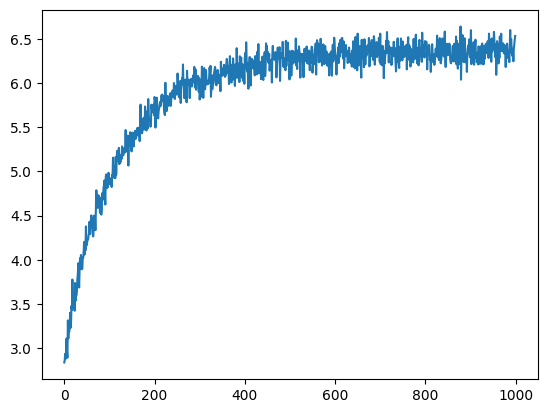

In [13]:
experiment = Experiment(CFG)
experiment.run()
experiment.plot_average_rewards()

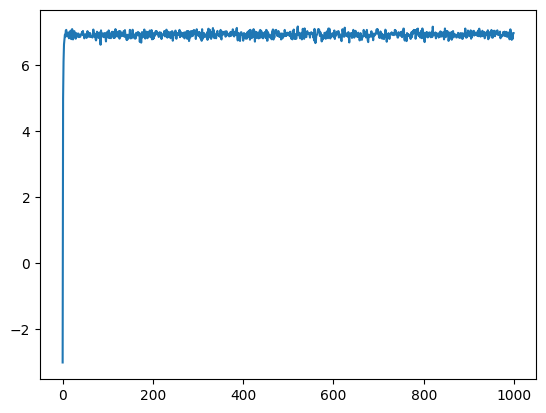

In [7]:
class CFG:
  k = 10
  reward_means = torch.randint(-3, 8, (k,)).float()
  reward_stds = torch.rand(k) + 3.0
  eps = 0.0
  iterations = 1000
  experiments = 2000

experiment = Experiment(CFG)
experiment.run()
experiment.plot_average_rewards()